## Imports

In [86]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_auc_score, precision_score, f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from matplotlib import pyplot as plt
import seaborn as sns
import operator
import math
from itertools import permutations, combinations
import pickle
from sklearn.utils import resample

def posant_accents(it):
    
    if type(it) == str:
        
        ##lletra ç
        
        if '\x87' in it:
            nova = it.replace('\x87','ç')
        else:
            nova = it

        ###lletra i
        if '¡' or 'Ã¯'or 'ï'or 'Ã\xad'or 'í' in nova:
            renova = nova.replace('¡', 'i').replace('Ã¯', 'i').replace('ï', 'i').\
            replace('Ã\xad', 'i').replace('í', 'i')
        else:
            renova = nova
        ###Lletra o
        if '\x95' or 'Ã³' or '¢' or 'ã³'or 'Ã²' or 'ò' in renova:
            trinova = renova.replace('\x95', 'o').replace('Ã³', 'o')\
            .replace('¢', 'o').replace('ã³', 'o').replace('Ã²', 'o').replace('ò', 'o')
        else:
            trinova = renova

        if '¢' in trinova:

            quatrinova = trinova.replace('¢', 'o')
        else:
            quatrinova = trinova

        ###lletra e
        if '\x82' or 'Ã©' or 'é' or 'è'or 'Ãš' or '\x8a' in quatrinova:
            cinquinova = quatrinova.replace('\x82', 'e').replace('Ã©', 'e').replace('é', 'e').replace('è', 'e').\
            replace('Ãš', 'e').replace('\x8a', 'e')
        else:
            cinquinova = quatrinova

        if '\x85' or 'Ã\xa0'in cinquinova:
            sixinova = cinquinova.replace('\x85', 'a').replace('Ã\xa0', 'a').replace('à', 'a')
        else:
            sixinova = cinquinova

        if 'Sarr' in sixinova:

            septinova = 'Sarria'
        else:
            septinova = sixinova

        if 'Ã§' in septinova:
            vuitinova = septinova.replace('Ã§', 'ç')
        else:
            vuitinova = septinova

        ##Lletra u
        if 'ãº' or 'ú' or '£'in vuitinova:
            nounova = vuitinova.replace('ãº', 'u').replace('ú', 'u').replace('£','u')
        else:
            nounova = vuitinova

        if 'ã³' or 'ó' in nounova:

            deunova = nounova.replace('ã³', 'o').replace('ó', 'o')
        else:
            deunova = nounova
    else:
        deunova = it
    
    return deunova

def remove_accents(word):
    
    return word.replace('à', 'a').replace('è','e').replace('é', 'e').replace('ï', 'i').replace('í', 'i').replace('ò','o').replace('ó', 'o').replace('ü','u').replace('ú', 'u')



def hasNumbers(inputString):
    
    return (any(char.isdigit() for char in inputString))

###FUNCTIONS


def sorting_by_corr(dataframe, features, target):
    
    """Sorting all features by its correlation with target"""
    
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    nova_data = pd.DataFrame()
    
    cols_to_transform = data[features].select_dtypes(include='object').columns
    nova_data = pd.get_dummies(dataframe[features], columns = cols_to_transform )
    
    nova_data[target] = dataframe[target]    
     
    correlation = nova_data.corr()
    print('Done with correlation')
    
    
    correlation[target] = [x if x >= 0 else (-1) * x for x in correlation[target]]
            
    
    all_features = list(correlation[target].sort_values(ascending=False)[1::].index)
    all_features.append(target)
    final_df = nova_data[all_features]
    all_features.remove(target)
    return all_features, final_df




def changing_threshold(proba, threshold_majority):
    
    """recalculating predictions based on threshold"""
    
    return [0 if x[0] >= threshold_majority else 1 for x in proba]

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return TP, FP, TN, FN


def selecting_features(dataframe, target, features):
    
    """Function to select features through combinationa"""
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)


    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    
    clf = LogisticRegression()        
    clf.fit(X_train_std, y_resampled)
    score = clf.score(X_test_std, y_test)
    pred = clf.predict(X_test_std)
    prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=0.5)
    
    return accuracy, recall, precision, f1, fbeta, prob, y_test


def selecting_features_corr(dataframe, target, features):
    
    """It is a similar function thatn the one with combinations. In this case, features
    are already separated and dummied"""
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)


    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    
    clf = LogisticRegression()        
    clf.fit(X_train_std, y_resampled)
    score = clf.score(X_test_std, y_test)
    pred = clf.predict(X_test_std)
    prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=0.5)
    
    return accuracy, recall, precision, f1, fbeta, prob, pred

### Pickling resultat

def pickling_resultat(resultat):
    
    for i in resultat.keys():
        with open('resultat{}.pkl'.format(i), 'wb') as picklefile:
            pickle.dump(resultat[i], picklefile)
            
def depickling_resultat(amount_features):
    resultat = {}
    for i in range (1, amount_features + 1):
        
        with open('resultat{}.pkl'.format(i), 'rb') as f:
            resultat[i] = pickle.load(f)
    return resultat

def selecting_model(dataframe, target, features, model):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2018, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.4, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    

                
    model.fit(X_train_std, y_resampled)
    pred = model.predict(X_test_std)
    #prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
        
    return accuracy, recall, precision, f1,auc 
    
    
def preprocessing_features(df, features):
    
    "Getting ready the features for the model"
    
    data = df[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            print(item, data[item].dtypes)
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    features_array = np.array(data)
    
    return features_array 


def selecting_model(dataframe, target, features, model):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2018, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.4, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    

                
    model.fit(X_train_std, y_resampled)
    pred = model.predict(X_test_std)
    #prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
        
    return accuracy, recall, precision, f1,auc 
    

accidents = pd.read_csv('/Users/fcbnyc/mystuff/repos/BarcelonaAccidents/total_accidents_2018.csv',)


##Defining target
accidents['target'] =\
[0 if a +b == 0 else 1 for a, b in zip(accidents['severe_injuries'],accidents['#_deaths'])]


accidents['target'].unique()

###I am trying to bucketize the streets counting the accidents and target per street.
######1. Clean up all the names
accidents['street'] = [remove_accents(posant_accents(x.strip().lower())) for x in accidents['street']]
accidents['street'] = accidents['street'].str.replace('av ', '')
accidents['street'] = accidents['street'].str.replace('gv corts catalanes', 'corts catalanes')
accidents['street'] = accidents['street'].str.replace('rda litoral', 'litoral').replace('litoral(llobre', 'litoral (llobregat)').\
replace('litoral(besos)', 'litoral (besos)')
accidents['street'] = accidents['street'].str.replace('rda dalt', 'dalt').replace('dalt(llobregat', 'dalt (llobregat)').\
replace("ca l'alegre dalt", "ca l'alegre de dalt").replace('trav dalt', 'dalt')
accidents['street'] = accidents['street'].str.replace('passeig de gracia', 'pg gracia')
accidents['street'] = accidents['street'].str.replace('xipre', 'xiprer')
accidents['street'] = accidents['street'].str.replace('xiprerr', 'xiprer')
accidents['street'] = accidents['street'].str.replace('ctra c-31', 'c-31')
accidents['street'] = accidents['street'].str.replace('rda general mitre', 'general mitre').replace('ronda general mitre', 'general mitre')
accidents['street'] = accidents['street'].str.replace('c. d zona franca', 'c zona franca')
accidents['street'] = accidents['street'].str.replace('vista-rica', 'vista rica')
accidents['street'] = accidents['street'].str.replace('rbla guipuscoa', 'guipuscoa')
accidents['street'] = accidents['street'].str.replace('via ', '')
accidents['street'] = accidents['street'].str.replace('avrepub argentina', 'republica argentina')
accidents['street'] = accidents['street'].str.replace('pg ', '')
######2. Split the crossing street in 2
merda = [(x, '') if '/' not in x else (x.split('/')[0].strip(), x.split('/')[1].strip())\
 for x in accidents['street']]
accidents['street_1'] = [x[0] for x in merda]
accidents['street_2'] = [x[1] for x in merda]
###correcting number of acidents and tragets in crossing roads
accidents['street_1_acc'] = [1 if x == '' else 0.5 for x in accidents['street_2']]
accidents['street_2_acc'] = [0 if x == '' else 0.5 for x in accidents['street_2']]
accidents['street_1_target'] = accidents['street_1_acc'] * accidents['target']
accidents['street_2_target'] = accidents['street_2_acc'] * accidents['target']


#######3. do the groupby per street_1 and street_2
street_1 = accidents.groupby('street_1').agg({'street_1_acc': 'sum', 'street_1_target': 'sum'}).sort_values('street_1_acc', ascending=False)
street_1.columns = ['accidents_1', 'targets_1']
street_2 = accidents.groupby('street_2').agg({'street_2_acc': 'sum', 'street_2_target': 'sum'}).sort_values('street_2_acc', ascending=False)
street_2.columns = ['accidents_2', 'targets_2']
######4. Merge, join, .... whatever the 2 groubyes
all_streets = pd.concat([street_1, street_2],axis=1)
#all_streets.fillna(0,inplace=True)
all_streets['accidents_x_street'] = all_streets[['accidents_1', 'accidents_2']].apply(lambda x: np.nansum(x), axis=1)
all_streets['target_x_street'] = all_streets[['targets_1', 'targets_2']].apply(lambda x: np.nansum(x), axis=1)
all_streets.drop(['', '0', 'a'],inplace=True)
all_streets['ratio_x_street'] = all_streets['target_x_street']/all_streets['accidents_x_street']
######5. I will calculate the ratio and number of accidents and taget per street 

accidents['crossing_corrector'] = [0.5 if '/' in x else 1 for x in accidents['street']]
[x for x in accidents.columns if 'crossing' in x]

a = all_streets['accidents_x_street'].to_dict()
accidents['acc_st_1'] = accidents['street_1'].map(a)
accidents['acc_st_2'] = accidents['street_2'].map(a)

accidents['accidents_street'] = accidents[['acc_st_1','acc_st_2']].apply(lambda x: np.nansum(x), axis=1)* accidents['crossing_corrector']
t = all_streets['target_x_street'].to_dict()
accidents['tar_st_1'] = accidents['street_1'].map(t)
accidents['tar_st_2'] = accidents['street_2'].map(t)
accidents['target_street'] = accidents[['tar_st_1','tar_st_2']].apply(lambda x: np.nansum(x), axis=1)* accidents['crossing_corrector']
accidents['ratio_street'] = accidents['target_street']/accidents['accidents_street']
accidents['ratio_street'].fillna(0,inplace=True)
accidents['zip_code'] = [x.replace(' ','').replace('-','') for x in accidents['zip_code']]
###I will use 6 quantiles
print(accidents['target'].sum())
accidents.drop(['Unnamed: 0', 'index'], axis=1,inplace=True)
features = [x for x in accidents.columns if hasNumbers(x) is False]
accidents.to_csv('accidents_pre_model_2018.csv')
print('Done')
accidents.head()

2201
Done


,#_deaths,amount_vehicles_involved,amount_victims,day_month,district,hour_day,incident_#,lat,latitude,long,...,street_1_target,street_2_target,crossing_corrector,acc_st_1,acc_st_2,accidents_street,tar_st_1,tar_st_2,target_street,ratio_street
0,0.0,1.0,0.0,28.0,Sant Martí,19.0,2010S003688,0.0,41.413148,0.0,...,0.0,0.0,1.0,1569.5,NaN,1569.5,33.5,NaN,33.5,0.021344
1,0.0,2.0,1.0,8.0,Sant Martí,11.0,2010S007597,0.0,41.414052,0.0,...,0.0,0.0,1.0,43.5,NaN,43.5,0.0,NaN,0.0,0.000000
2,0.0,1.0,1.0,25.0,Sant Martí,13.0,2010S001390,0.0,41.414682,0.0,...,0.0,0.0,1.0,411.5,NaN,411.5,9.5,NaN,9.5,0.023086
3,0.0,2.0,1.0,3.0,Sant Martí,14.0,2010S005416,0.0,41.409990,0.0,...,0.0,0.0,1.0,87.5,NaN,87.5,3.5,NaN,3.5,0.040000
4,0.0,2.0,2.0,24.0,Sant Martí,14.0,2010S008924,0.0,41.413018,0.0,...,0.0,0.0,1.0,303.5,NaN,303.5,11.0,NaN,11.0,0.036244


In [9]:
##Zip code is actually the number of the street: something already obtained via lat and long etc

features_to_remove = ['lat', 'long', '#_deaths', 'incident_#','amount_victims', 'minor_injuries',\
                     'severe_injuries', 'street', 'street_code', 'target', 'zip_code']
for x in features_to_remove:
    features.remove(x)


target = 'target'
random_state = 2019
models_dict = {'log_reg': {'name': LogisticRegression(C= 100, random_state=random_state)},
'forest':{'name': RandomForestClassifier(min_samples_leaf=50, max_depth=3, n_estimators=20, max_features=3)}, 
'gbc': {'name': GradientBoostingClassifier(random_state=random_state)},
       'linearsvc':{'name': LinearSVC(C=1.0, random_state=random_state)},\
              'Perceptron': {'name': Perceptron(random_state=random_state)},
              'DecisionTree':{'name': DecisionTreeClassifier(random_state=random_state)}}
resultats = {key:{} for key in models_dict.keys()}
metrics = ['accuracy', 'recall', 'precision', 'f1','auc']
for key in resultats.keys():
    for metric in metrics:
        resultats[key][metric] = []
for i in models_dict.keys():
    print(models_dict[i]['name'])

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2019, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_w

In [10]:
llista, df = sorting_by_corr(accidents, features,target)

Done with correlation


In [11]:
for model in models_dict.keys():
    print(model)
    for x in range(10,len(llista), 10):
        
        a,b,c,d,e = selecting_model(df, target, llista[0:x], models_dict[model]['name'])
        resultats[model]['accuracy'].append(a)
        resultats[model]['recall'].append(b)
        resultats[model]['precision'].append(c)
        resultats[model]['f1'].append(d)
        resultats[model]['auc'].append(e)
        print(x, '\n','Area Under the Curve: ', e,'\n','Recall: ', b,)
pickling_resultat(resultats)

log_reg
10 
 Area Under the Curve:  0.6615123658266561 
 Recall:  0.3924242424242424
20 
 Area Under the Curve:  0.6742177356297928 
 Recall:  0.42272727272727273
30 
 Area Under the Curve:  0.6814266311820166 
 Recall:  0.4393939393939394
40 
 Area Under the Curve:  0.6895232407719586 
 Recall:  0.45606060606060606
50 
 Area Under the Curve:  0.6841887070818657 
 Recall:  0.44696969696969696
60 
 Area Under the Curve:  0.6838730754240105 
 Recall:  0.44696969696969696
70 
 Area Under the Curve:  0.6968584487660475 
 Recall:  0.47424242424242424
80 
 Area Under the Curve:  0.695777290780447 
 Recall:  0.4712121212121212
90 
 Area Under the Curve:  0.6978330212883989 
 Recall:  0.47575757575757577
100 
 Area Under the Curve:  0.6967203599157359 
 Recall:  0.47424242424242424
110 
 Area Under the Curve:  0.7010685446750309 
 Recall:  0.48333333333333334
120 
 Area Under the Curve:  0.7018063934539907 
 Recall:  0.48484848484848486
130 
 Area Under the Curve:  0.6968072184003692 
 Recall:

/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


110 
 Area Under the Curve:  0.5 
 Recall:  0.0


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


120 
 Area Under the Curve:  0.5 
 Recall:  0.0


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


130 
 Area Under the Curve:  0.5 
 Recall:  0.0
140 
 Area Under the Curve:  0.5007378487789598 
 Recall:  0.0015151515151515152
150 
 Area Under the Curve:  0.5006983948217278 
 Recall:  0.0015151515151515152


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


160 
 Area Under the Curve:  0.5 
 Recall:  0.0


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


170 
 Area Under the Curve:  0.5 
 Recall:  0.0
180 
 Area Under the Curve:  0.4999605460427681 
 Recall:  0.0


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


190 
 Area Under the Curve:  0.5 
 Recall:  0.0


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


200 
 Area Under the Curve:  0.5 
 Recall:  0.0


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


210 
 Area Under the Curve:  0.5 
 Recall:  0.0
gbc
10 
 Area Under the Curve:  0.5218357328512778 
 Recall:  0.048484848484848485
20 
 Area Under the Curve:  0.5162129461584998 
 Recall:  0.03333333333333333
30 
 Area Under the Curve:  0.5163115810515796 
 Recall:  0.03333333333333333
40 
 Area Under the Curve:  0.5127012450712443 
 Recall:  0.025757575757575757
50 
 Area Under the Curve:  0.5133799129143563 
 Recall:  0.02727272727272727
60 
 Area Under the Curve:  0.5088936393047495 
 Recall:  0.01818181818181818
70 
 Area Under the Curve:  0.5104679717557489 
 Recall:  0.021212121212121213
80 
 Area Under the Curve:  0.5111269126202449 
 Recall:  0.022727272727272728
90 
 Area Under the Curve:  0.5088147313902857 
 Recall:  0.01818181818181818
100 
 Area Under the Curve:  0.5111269126202449 
 Recall:  0.022727272727272728
110 
 Area Under the Curve:  0.5096906690195572 
 Recall:  0.019696969696969695
120 
 Area Under the Curve:  0.5073982147682139 
 Recall:  0.015151515151515152
13

/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


10 
 Area Under the Curve:  0.5894258612320634 
 Recall:  0.3878787878787879


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


20 
 Area Under the Curve:  0.6383779999952177 
 Recall:  0.5287878787878788


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


30 
 Area Under the Curve:  0.6120271204110864 
 Recall:  0.4393939393939394


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


40 
 Area Under the Curve:  0.616428269119029 
 Recall:  0.39090909090909093


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


50 
 Area Under the Curve:  0.5900597548115895 
 Recall:  0.35454545454545455


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


60 
 Area Under the Curve:  0.6338222037306706 
 Recall:  0.4575757575757576


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


70 
 Area Under the Curve:  0.6504376400316588 
 Recall:  0.49242424242424243


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


80 
 Area Under the Curve:  0.6433612141297772 
 Recall:  0.43333333333333335


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


90 
 Area Under the Curve:  0.659937495367149 
 Recall:  0.47575757575757577


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


100 
 Area Under the Curve:  0.6499426722045676 
 Recall:  0.44696969696969696


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


110 
 Area Under the Curve:  0.6434563220781953 
 Recall:  0.44393939393939397


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


120 
 Area Under the Curve:  0.6501882431989747 
 Recall:  0.4712121212121212


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


130 
 Area Under the Curve:  0.6547484033103066 
 Recall:  0.453030303030303


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


140 
 Area Under the Curve:  0.6218340590470315 
 Recall:  0.40606060606060607


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


150 
 Area Under the Curve:  0.6578779390209202 
 Recall:  0.47424242424242424


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


160 
 Area Under the Curve:  0.639148189063363 
 Recall:  0.45


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


170 
 Area Under the Curve:  0.647027502994914 
 Recall:  0.4590909090909091


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


180 
 Area Under the Curve:  0.6561425626899469 
 Recall:  0.4893939393939394


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


190 
 Area Under the Curve:  0.6611181849266754 
 Recall:  0.5015151515151515


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


200 
 Area Under the Curve:  0.6533139530713112 
 Recall:  0.4954545454545455


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


210 
 Area Under the Curve:  0.6585695788469401 
 Recall:  0.5045454545454545
DecisionTree
10 
 Area Under the Curve:  0.5492556951189477 
 Recall:  0.13484848484848486
20 
 Area Under the Curve:  0.56130565100225 
 Recall:  0.15303030303030302
30 
 Area Under the Curve:  0.5492633467955018 
 Recall:  0.12878787878787878
40 
 Area Under the Curve:  0.5473851590950936 
 Recall:  0.12424242424242424
50 
 Area Under the Curve:  0.5477796986674127 
 Recall:  0.12424242424242424
60 
 Area Under the Curve:  0.5501707878118358 
 Recall:  0.12878787878787878
70 
 Area Under the Curve:  0.5497170673036689 
 Recall:  0.12878787878787878
80 
 Area Under the Curve:  0.5524711926333484 
 Recall:  0.13484848484848486
90 
 Area Under the Curve:  0.5430567013144145 
 Recall:  0.11515151515151516
100 
 Area Under the Curve:  0.543952365922302 
 Recall:  0.11666666666666667
110 
 Area Under the Curve:  0.5474837939881734 
 Recall:  0.12424242424242424
120 
 Area Under the Curve:  0.5524514656547325 
 Re

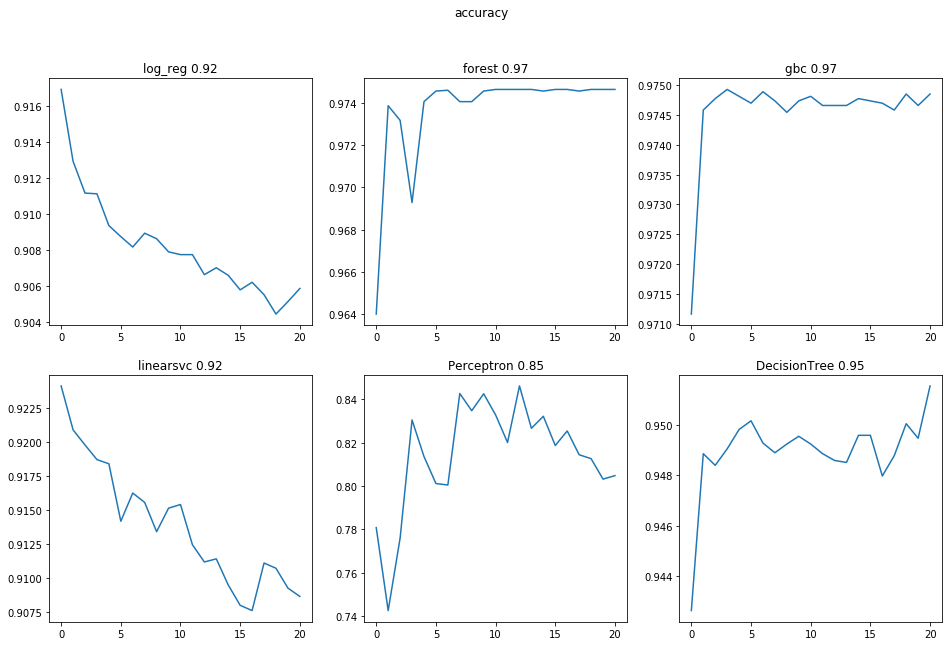

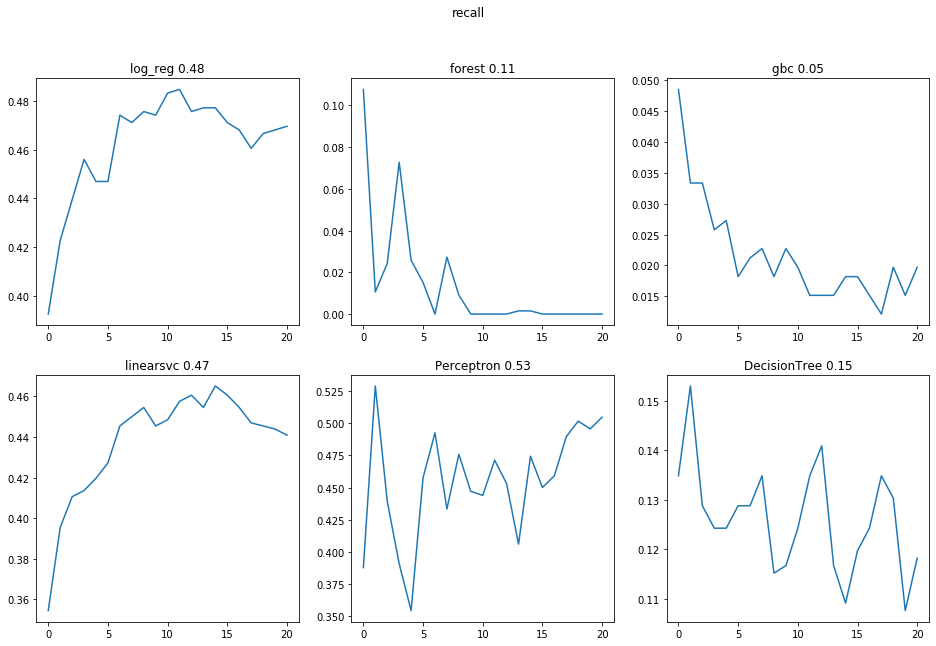

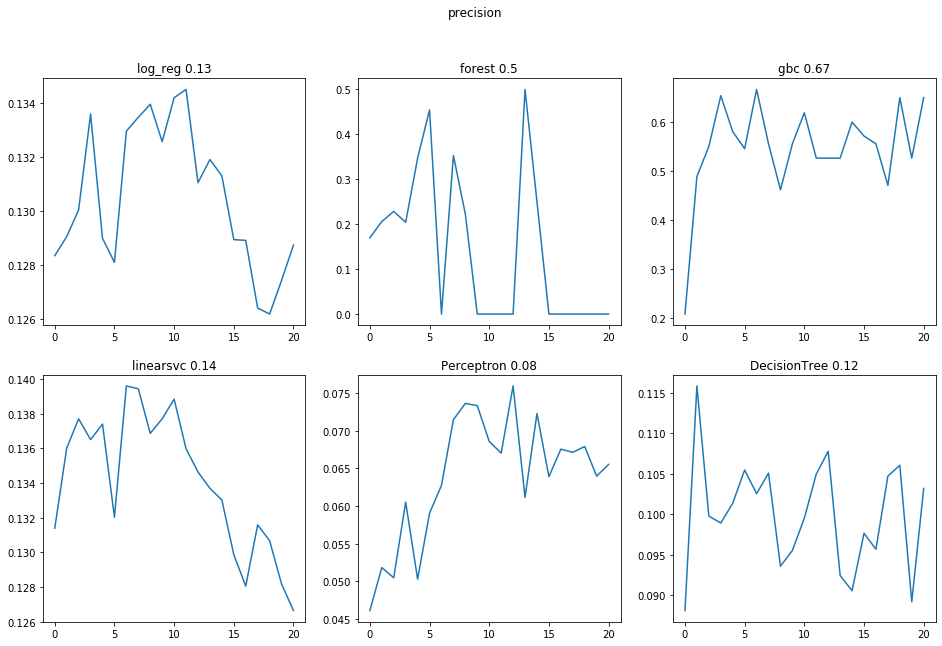

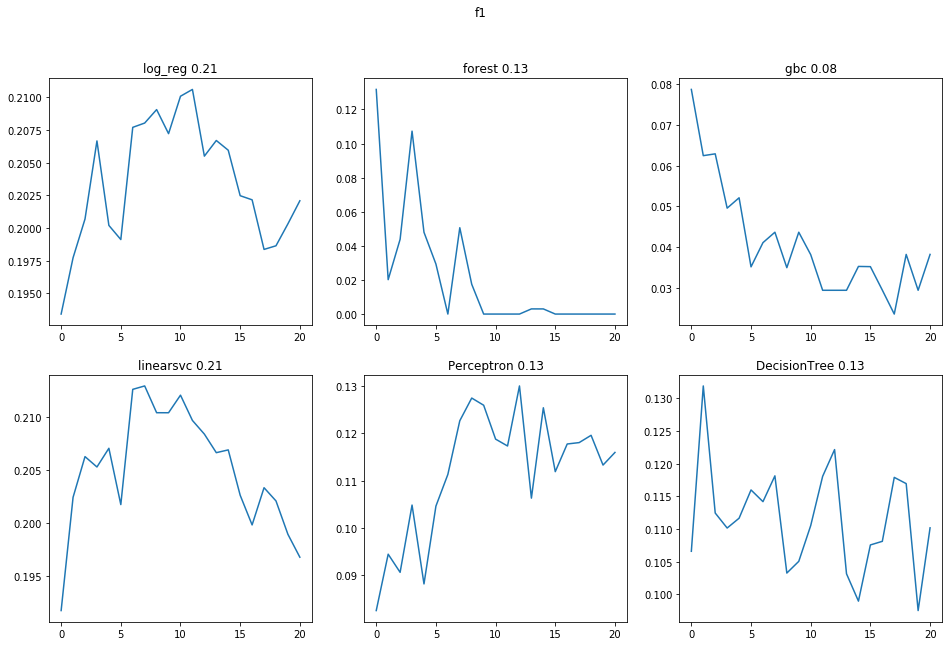

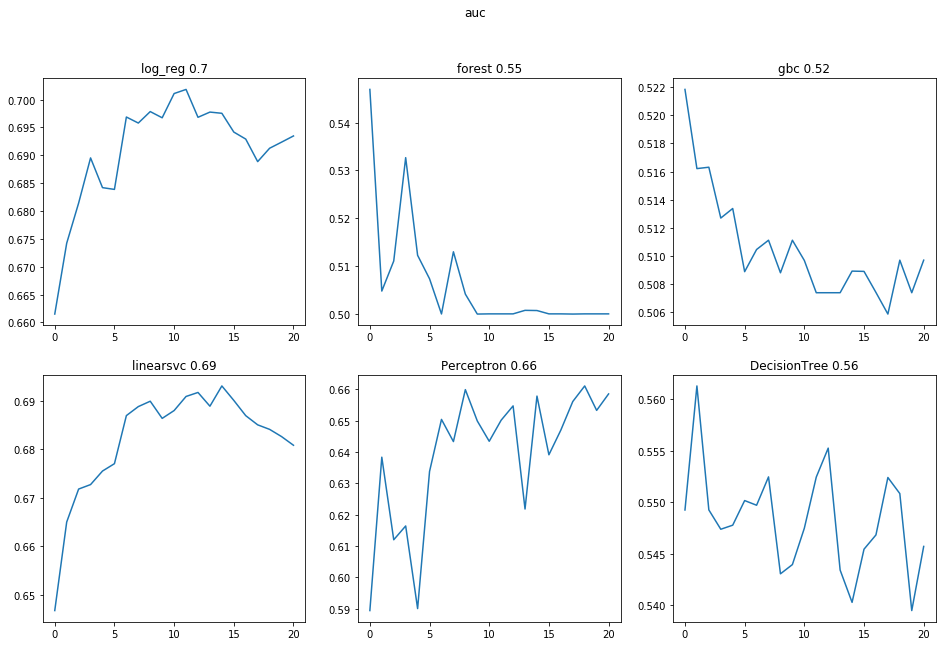

In [66]:
for metric in metrics:
    fig = plt.figure(figsize=(16,10))
    #metric = 'recall'
    plt.suptitle(metric)
    count = 0
    for key in resultats.keys():
        count+=1
        #print(key, max(resultats[key][metrics[x]]))
        plt.subplot(2,3,count)
        plt.plot(resultats[key][metric], label=key)
        plt.title(key + ' '+ str(round(max(resultats[key][metric]),2)))
        #plt.legend(loc='best')

In [81]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.8.0


In [72]:
from keras.models import Sequential
from keras.layers import Dense

In [76]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', input_dim=8))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid'))

In [85]:
#Compiling the neural network
tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_, labels=tf.ones_like(D_))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=10, epochs=100)

NameError: name 'D_logits_' is not defined

In [ ]:
###Try with different models
metrics = ['recall', 'precision', 'f1_score', 'fbeta', 'accuracy']
for key in models_dict.keys():
    models_dict[key].update({key: None for key in metrics}) 


for key in models_dict.keys():
    
    accuracies = []
    recalls =[]
    precisions = []
    f1s = []
    count = 0
    for i in features:
        
        count = count + 1
        a, r, p, f = selecting_model(df,target, i, models_dict[key]['name'])
        
        accuracies.append(a)
        recalls.append(r)
        precisions.append(p)
        f1s.append(f)
        print(count)
        
    models_dict[key]['accuracy'] = accuracies
    models_dict[key]['recall'] = recalls
    models_dict[key]['precision'] = precisions
    models_dict[key]['f1_score'] = f1s
    print(key)


In [ ]:
with open('dictioanry_models.pkl', 'wb') as picklefile:
    pickle.dump(models_dict, picklefile)

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['accuracy']) + 1)]
    plt.plot(x_axis,models_dict[key]['accuracy']);
    plt.title('Accuracy')
plt.legend(models_dict.keys());

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['recall']) + 1)]
    plt.plot(x_axis,models_dict[key]['recall']);
    plt.title('Recall')
plt.legend(models_dict.keys());

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['precision']) + 1)]
    plt.plot(x_axis,models_dict[key]['precision']);
    plt.title('Precision')
plt.legend(models_dict.keys());

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['f1_score']) + 1)]
    plt.plot(x_axis,models_dict[key]['f1_score']);
    plt.title('F1 Score')
plt.legend(models_dict.keys());

In [ ]:
msk = np.random.rand(len(df)) < 0.70
msk.sum(), df.shape[0] * 0.70
train = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

len(train) - sum(train['victims_alert']), sum(train['victims_alert'])

In [ ]:
####Oversampling minority
###Trying SVC with penalisation.
msk = np.random.rand(len(df)) < 0.70
msk.sum(), df.shape[0] * 0.70
train = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]


train_majority = train[train.victims_alert==0]

train_minority = train[train.victims_alert==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=52101,    # to match majority class
                                 random_state=1) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
train_upsampled.victims_alert.value_counts()

y = train_upsampled.victims_alert
X = preprocessing_features(train_upsampled, features[10])
y_test = test.victims_alert
X_test = preprocessing_features(test, features[10]) 

# Train model
clf_1 = LogisticRegression().fit(X, y)
clf_2 = Perceptron().fit(X,y)
#clf_3 = SVC(kernel='linear', 
            #class_weight='balanced', # penalize
            #probability=True).fit(X,y) 
# Predict on training set
pred_y_1 = clf_1.predict(X_test)
pred_y_2 = clf_2.predict(X_test)
#pred_Y_3 = clf_3.predict(X_test)
 
# Is our model still predicting just one class?
#print( np.unique( pred_y_1 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y_test, pred_y_1) )
print( accuracy_score(y_test, pred_y_2) )
#print( accuracy_score(y_test, pred_y_3) )
# 0.513888888889
print(recall_score(y_test, pred_y_1))
print(recall_score(y_test, pred_y_2))
#print(recall_score(y_test, pred_y_3))

In [ ]:
print(pred_y_1.sum(), len(pred_y_1), len(pred_y_1) *0.25, pred_y_1.sum()/len(pred_y_1))
print(pred_y_2.sum(), len(pred_y_2), len(pred_y_2) *0.25, pred_y_2.sum()/len(pred_y_2))
print(pred_y_3.sum(), len(pred_y_3), len(pred_y_3) *0.25, pred_y_3.sum()/len(pred_y_3))

In [ ]:
train = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

train_majority = train[train.victims_alert==0]

train_minority = train[train.victims_alert==1]
 
# Upsample minority class

train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1359,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

 
# Display new class counts
#train_upsampled.victims_alert.value_counts()

y = train_downsampled.victims_alert
X = preprocessing_features(train_downsampled, features[10])
y_test = test.victims_alert
X_test = preprocessing_features(test, features[10]) 

# Train model
clf_1 = LogisticRegression().fit(X, y)
clf_2 = Perceptron().fit(X,y)
clf_3 = RandomForestClassifier().fit(X,y) 
# Predict on training set
pred_y_1 = clf_1.predict(X_test)
pred_y_2 = clf_2.predict(X_test)
pred_y_3 = clf_3.predict(X_test)
 
# Is our model still predicting just one class?
#print( np.unique( pred_y_1 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y_test, pred_y_1) )
print( accuracy_score(y_test, pred_y_2) )
print( accuracy_score(y_test, pred_y_3) )
# 0.513888888889
print(recall_score(y_test, pred_y_1))
print(recall_score(y_test, pred_y_2))
print(recall_score(y_test, pred_y_3))

In [ ]:
print(pred_y_1.sum(), len(pred_y_1), len(pred_y_1) *0.25, pred_y_1.sum()/len(pred_y_1))
print(pred_y_2.sum(), len(pred_y_2), len(pred_y_2) *0.25, pred_y_2.sum()/len(pred_y_2))

In [ ]:
###Trying SVC with penalisation.

df['balance'].value_counts()


def selecting_model(dataframe, target, features, model):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    

                
    model.fit(X_train_std, y_resampled)
    pred = model.predict(X_test_std)
    #prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
        
    return accuracy, recall, precision, f1

In [ ]:
###chapter 2

class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [ ]:


def selecting_model(dataframe, target, features, **models_dict):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    
    for item in models_dict.keys():

        
  
        clf = models_dict[item]['name']
            
        clf.fit(X_train_std, y_resampled)
        score = clf.score(X_test, y_test)
        pred = clf.predict(X_test_std)
        #prob = clf.predict_proba(X_test_std)
        accuracy = accuracy_score(y_test, pred)
        recall = recall_score(y_test, pred)
        #models_dict[item]['pred'].append(pred)
        #models_dict[item]['proba'].append(prob)
        #models_dict[item]['accuracy'].append(accuracy)
        #models_dict[item]['recall'].append(recall)
        #models_dict[key]['count'].append(num)
        print(str(models_dict[item]))
        print('Misclassified samples: %d' % (y_test != pred).sum())
        print('Amount of victims predicted: ', pred.sum())
        print("How many predictions over real: ", pred.sum()/y_test.sum())
        print("Predicted one vs total compared with original: ", pred.sum()/len(y_test), y_test.sum()/len(y_test))
        print('Victims_alert missed: ',  sum([1 for x,y in zip(y_test,pred) if x ==1 and y==0]))

        print('Accuracy: %.4f' % accuracy_score(y_test, pred))
        print('Recall: {}'.format(recall_score(y_test, pred)))
        print('Precision: {}'.format(precision_score(y_test, pred)))
        print('f1_score: {}'.format(f1_score(y_test, pred)))
        print('fbeta_score: {}'.format(fbeta_score(y_test, pred, beta=0.5)))
    
    
    


In [ ]:
selecting_model(df, target,features_max_f1_score[1], **models_dict)

In [ ]:
from sklearn.svm import SVC
SVC()

In [ ]:
def preprocessing_features(df, features):
    
    "Getting ready the features for the model"
    
    data = df[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            print(item, data[item].dtypes)
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    features_array = np.array(data)
    
    return features_array
preprocessing_features(df,)

In [ ]:
a = np.array([1,0,1,0,0,0])
b = np.array([0,0,1,0,0,0])
sum([1 for x,y in zip(a,b) if x ==1 and y==0])

In [ ]:
features_array = preprocessing_features(df, all_features)

In [ ]:
X = features_array
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    
    """loading initial information"""
    
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        """calculate score with all features included initialy in X"""
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        "while the number of initial features is bigger than the value k_features given"

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        
        """Preparing the X based on selected features"""
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        
        """scoreing the model based on gthe selected features selected by indices"""
        
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
numeric_fetuares = df[all_features].select_dtypes(exclude='object').columns

In [ ]:
X = np.array(df[numeric_fetuares])
y = df[target].values
knn = KNeighborsClassifier(n_neighbors=5)
# selecting features
sbs = SBS(knn, k_features=1)
#sbs.fit(X_train_std, y_train)
sbs.fit(X, y)

In [ ]:

def _calc_score(X_train, y_train, X_test, y_test):
        pp = Perceptron()
        pp.fit(X_train, y_train)
        y_pred = pp.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        return score, y_pred, y_test
    
dim = X_train.shape[1]
indices_ = tuple(range(dim))
subsets_ = [indices_]
score, pred, real = _calc_score(X_train, y_train, 
                                 X_test, y_test)

In [ ]:
len(all_features)

In [ ]:
len(pred), len(real), pred.sum(), real.sum()
misclassified_samples = []
cagades = []

for x,y in zip(real,pred):
    if x != y:
        misclassified_samples.append(1)
    
print('Misclassified Samples: ', sum(misclassified_samples))

In [ ]:
score

In [ ]:
from sklearn.base import clone

In [ ]:
models = ['Perceptron', 'LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier',\
          'KNeighborsClassifier']
for itrem in models:    
    calculant_recall(df,target, features, itrem)

In [ ]:
for i in df.columns:
    print(i, len(df[i].unique()))

print('Number of Nan;', df.isnull().sum().sum())

In [ ]:
len(y_pred), y_pred.sum()

In [ ]:
##Calculate recall
evaluation_metrics['recall'], evaluation_metrics['precision']
##THIS ONE SUCKS

In [ ]:
##SECOND TRY-----ADDING FEATURES

In [ ]:
##we will add some features
set_features = ['hour_day', 'month', 'latitude', 'longitude', 'year', 'victims_alert']

df1 = (pd.concat([df[set_features], pd.get_dummies(df['month'])], axis=1, join_axes=[df.index])).drop('month', axis= 1)  

first_set_features = df1.columns
first_set_features.drop('victims_alert')

In [ ]:
def preprocess_features(df1):
    """Prepares input features from accidents.

    Args:
    final_accidents dataframe: A Pandas DataFrame expected to contain data
      from the Barcelona Accidents.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = df1[first_set_features]
    processed_features = selected_features.copy()
    return processed_features

def preprocess_targets(df1):
    """Prepares target features (i.e., labels) from BarcelonaAccidents data set.

    Args:
    final_accidents_dataframe: A Pandas DataFrame expected to contain data
      from the BarcelonaAccidents data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Create a boolean categorical feature representing whether the
    # median_house_value is above a set threshold.
    output_targets["victims_alert"] = df1["victims_alert"].astype(float)
    return output_targets

msk = np.random.rand(len(df1)) < 0.75
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(df1[msk])
training_targets = preprocess_targets(df1[msk])

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(df1[~msk])
validation_targets = preprocess_targets(df1[~msk])

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

In [ ]:


def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

    Returns:
    A `LinearClassifier` object trained on the training data.
    """

    periods = 12
    steps_per_period = steps / periods

    # Create a linear classifier object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["victims_alert"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["victims_alert"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["victims_alert"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on validation data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        # Compute training and validation loss.
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        # Occasionally print the current loss.
        print("  period {:02d} : {:0.2f}".format(period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
    
    

    #validation_predictions = np.array([item['probabilities'] for item in validation_probabilities])

    _ = plt.hist(validation_predictions)

    evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

    print("AUC on the validation set: {:0.4f}".format(evaluation_metrics['auc']))
    print("Accuracy on the validation set: {:0.6f}".format(evaluation_metrics['accuracy']))
    print("AUC_precision-recall {:0.5f}".format(evaluation_metrics['auc_precision_recall']))

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        if not any(x in variable 
            for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size

In [ ]:
for item in np.linspace(0,1, 5):
    linear_classifier = train_linear_classifier_model(
        learning_rate=0.000005,
        # TWEAK THE REGULARIZATION VALUE BELOW
        regularization_strength =item,
        steps=500,
        batch_size=100,
        feature_columns =construct_feature_columns(training_examples),
        training_examples=training_examples,
        training_targets=training_targets,
        validation_examples=validation_examples,
        validation_targets=validation_targets)
    print("Model size:", model_size(linear_classifier))

In [ ]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["victims_alert"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['probabilities'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: {:0.4f}".format(evaluation_metrics['auc']))
print("Accuracy on the validation set: {:0.2f}".format(evaluation_metrics['accuracy']))
print("AUC_precision-recall {:0.3f}".format(evaluation_metrics['auc_precision_recall']))

validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

average_precision = average_precision_score(validation_targets, validation_probabilities)
precision, recall, _ = precision_recall_curve(validation_targets, validation_probabilities)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
##Calculate recall
evaluation_metrics['recall'], evaluation_metrics['precision']
##THIS ONE SUCKS but it doesn't?

## THIRD TRY--- ALL FEATURES AND REGLARIZATION

In [ ]:
a = [1,2,3]

In [ ]:
##we will add some features
set_features = ['hour_day', 'month', 'latitude', 'longitude', 'year', 'victims_alert', 'week_day']

df2 = (pd.concat([df[set_features], pd.get_dummies(df[['month', 'week_day']])], axis=1, join_axes=[df.index])).drop(['month', 'week_day'], axis= 1)  

first_set_features = df2.columns

def preprocess_features(df2):
    """Prepares input features from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = df2[first_set_features]
    processed_features = selected_features.copy()
    processed_features["latxlong"] = (
    df2["latitude"] * df2["longitude"])
    return processed_features

def preprocess_targets(df2):
    """Prepares target features (i.e., labels) from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Create a boolean categorical feature representing whether the
    # median_house_value is above a set threshold.
    output_targets["victims_alert"] = df2["victims_alert"].astype(float)
    return output_targets

In [ ]:
msk = np.random.rand(len(df2)) < 0.75
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(df2[msk])
training_targets = preprocess_targets(df2[msk])

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(df2[~msk])
validation_targets = preprocess_targets(df2[~msk])

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

In [ ]:
##It is better to use a low learning rate to ensure convergence

linear_classifier = train_linear_classifier_model(
    learning_rate=0.000001,
    # TWEAK THE REGULARIZATION VALUE BELOW
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

In [ ]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["victims_alert"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['probabilities'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

In [ ]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: {:0.4f}".format(evaluation_metrics['auc']))
print("Accuracy on the validation set: {:0.5f}".format(evaluation_metrics['accuracy']))
print("AUC_precision-recall {:0.3f}".format(evaluation_metrics['auc_precision_recall']))

validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

In [ ]:
average_precision = average_precision_score(validation_targets, validation_probabilities)
precision, recall, _ = precision_recall_curve(validation_targets, validation_probabilities)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
lr1 =LogisticRegression()
lr.fit(X_test, y_test)
prediction = lr.predict_proba(X_resampled)
accuracy_score(y_train, prediction)
recall_score(y_resampled, prediction)

In [ ]:
names = ["Logistic Regression", "Random Forest", "Gradient Boost Classifier"]
classifiers = [
    LogisticRegression(C= 2),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GradientBoostingClassifier()]
#model_list = ['logreg']
logreg_score = []
rf_score = []
gbc_score = []
logreg_recall = []
rf_recall = []
gbc_recall = []
accidents.drop(['#_deaths', 'amount_victims', 'incident_#', 'minor_injures', 'severely_injured', 'victims'],\
               axis=1, inplace=True)


objectes = accidents.select_dtypes(include='object').columns
numerical = accidents.select_dtypes(exclude='object').columns
print('Object_columns:', objectes, len(objectes))
print('Numerical_columns:', numerical, len(numerical))
print('Ha de ser zero:', len(accidents.columns) - len(numerical) - len(objectes))
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numerical], dummies], axis=1)

correlation = final.corr()
#correlation['victims_alert'].head(10)

pos_values = []
for item in correlation['victims_alert']:
    if item < 0:
        item = item * (-1)
        pos_values.append(item)
    else:
        pos_values.append(item)
correlation['victims_alert'] = pos_values
all_features = list(correlation['victims_alert'].sort_values(ascending=False)[1::].index)
for num in range(2,len(all_features), 2):
    
    fea = all_features[0:num]
    X = final[fea]
    y = accidents['victims_alert'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    if (y.sum()/final.shape[0]) < 0.05:
    
        X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_resampled)
        Xs_test = scaler.transform(X_test)

    else:
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_train)
        Xs_test = scaler.transform(X_test)

    
    for name, clf in zip(names, classifiers):
        
        clf.fit(Xs_train, y_resampled)
        score = clf.score(Xs_test, y_test)
        pred = clf.predict(Xs_test)
        prob = clf.predict_proba(X_test)
        new_proba = []
        for l in range(0,len(prob)):
            z = prob[l][1]
            new_proba.append(z)
        
        

            hedging_all = y.sum() * (2)
            new_pred = [hedging_all + 1]

            limits = np.linspace(0.0253,0.03, 20)
            i = 0
            
            while i < len(limits) and sum(new_pred) > hedging_all:

                numero = limits[i]
    
                #for numero in np.linspace(0.0253,0.03, 20):
                #new_pred = [1960]
                    #while sum(new_pred) > y.sum():
                new_pred = []
                for item in new_proba:
                    if item > numero:
                        new_pred.append(1)
                    else:
                        new_pred.append(0)

                i += 1

    
            recall = recall_score(y_test, new_pred)

    
        #recall = recall_score(y_test, pred)
        print(name, score)
        if name == 'Logistic Regression':
            logreg_score.append(score)
            logreg_recall.append(recall)
            print(name, score)
        elif name == "Random Forest":
            rf_score.append(score)
            rf_recall.append(recall)
        elif name == "Gradient Boost Classifier":
            gbc_score.append(score)
            gbc_recall.append(recall)
            
"""X = accidents[['amount_vehicles_involved', 'day_month',
        'hour_day', 'point_x', 'point_y',
        'street_code', 'year']]
y = accidents['victims_alert'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2018)"""

#pred = lr.predict(X_test)


####METRICS






x = []
for item in range(2, len(all_features), 2):
    x.append(item)
plt.plot(x, logreg_score, c='y')
plt.plot(x, rf_score, c='r')
plt.plot(x, gbc_score, c='b')
plt.axhline(baseline);

###Change metrics: no accuracy but to attend all the requested cases TruePositives/all_positives is 
###called tru positive rate or recall


In [ ]:
maxim_logreg = 0
for features,y in zip(x, logreg_score):
    if y > maxim_logreg:
        maxim_logreg = y
print(maxim_logreg)

logreg_serie = pd.Series(data=logreg_score, index=x)
print('logreg max:', logreg_serie[logreg_serie == maxim_logreg])

maxim_rf = 0
for features,y in zip(x, rf_score):
    if y > maxim_rf:
        maxim_rf = y
#print(maxim_rf)

rf_serie = pd.Series(data=rf_score, index=x)
print('rf max:', rf_serie[rf_serie == maxim_rf])

maxim_gbc = 0
for features,y in zip(x, gbc_score):
    if y > maxim_gbc:
        maxim_gbc = y
#print(maxim_rf)

gbc_serie = pd.Series(data=gbc_score, index=x)
print('rf max:', gbc_serie[gbc_serie == maxim_rf])

In [ ]:
if model == str(logreg):
            
            
            lr = LogisticRegression()
            
            lr.fit(Xs_train, y_train)
            pred = lr.predict(Xs_test)
            score = accuracy_score(y_test, pred)
            logreg_score.append(score)
        
        elif model == randomforest:
            
            rf = RandomForestClassifier()
            rf.fit(Xs_train, y_train)
            pred = rf.predict(Xs_test)
            score = accuracy_score(y_test, pred)
            rf_score.append(score)
        else:
            
            gbc = GradientBoostingClassifier()
            gbc.fit(Xs_train, y_train)
            pred = gbc.predict(Xs_test)
            score = accuracy_score(y_test, pred)
            gbc_score.append(score)
            
plt.plot(range(range(2,len(all_features), 2)), logreg_score)

In [ ]:
correlation['victims_alert'].sort_values(ascending=False)

In [ ]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.

    Returns:
    A set of feature columns
    """

    bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
    bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
    bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

    long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

    feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
    return feature_columns

## Binary Classification

In [ ]:
def binary_class(target, features, data, model):
    
    
    
    objectes = data[features].select_dtypes(include='object').columns
    numericals = data[features].select_dtypes(exclude='object').columns
    #dummies = pd.get_dummies(data[objectes])
    #final = pd.concat([data[numericals], dummies], axis=1)
    #list(features).remove(target)
    X = data[prova_features]
    y = data[target].reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)
    if (y.sum()/len(data)) < 0.05:
        
        X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=218).fit_sample(X_train, y_train)
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_resampled)
        Xs_test = scaler.transform(X_test)
    params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.01, 0.99, 5)}

    grid_search = GridSearchCV(model,
                          params,
                          verbose=1,
                          n_jobs=-1)

    grid_search.fit(Xs_train, y_resampled)
    print(grid_search.best_params_)
    lr_hyperparams = grid_search.best_estimator_
    pred = grid_search.predict(Xs_test)
    score = accuracy_score(y_test, pred)
    conf = classification_report(y_test, pred)
    baseline = 1 - (y.sum()/len(data))
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    
    return 'Baseline:', baseline, 'Score:', score, lr_hyperparams


binary_class('victims_alert', prova_features, df2, LogisticRegression(random_state=2018))

In [ ]:
xx = list(first_set_features)
xx.append('visca')
tt = 'visca'
print(xx)
xx.remove(tt, target)
print(xx)

In [ ]:
print(len(first_set_features))
tt = 'victims_alert'
prova_features = [x for x in first_set_features if x != tt]
prova_features

In [ ]:
###LogReg
target = accidents['victims_alert']
X = final[all_features[0:12]]
y = target.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)

if (y.sum()/len(accidents)) < 0.05:
        
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_resampled)
    Xs_test = scaler.transform(X_test)
params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.01, 0.99, 5)}

grid_search = GridSearchCV(LogisticRegression(random_state=2018),
                    params,
                    verbose=2,
                    n_jobs=-1)

grid_search.fit(Xs_train, y_resampled)
print(grid_search.best_params_)
lr_hyperparams = grid_search.best_estimator_
pred_logreg = grid_search.predict(Xs_test)
score_logreg = accuracy_score(y_test, pred)
conf = classification_report(y_test, pred)
baseline = 1 - (y.sum()/len(accidents))


In [ ]:
pred_logreg.sum(), score_logreg, baseline-score_logreg

In [ ]:
###RAndom Forest

target = accidents['victims_alert']
objectes = accidents[initial_features].select_dtypes(include='object').columns
numericals = accidents[initial_features].select_dtypes(exclude='object').columns
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numericals], dummies], axis=1)
X = final
y = target.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)

if (y.sum()/len(accidents)) < 0.05:
        
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_resampled)
    Xs_test = scaler.transform(X_test)
params = {
    'max_depth': [2,3,4, 5],
    'n_estimators': [6, 8, 10, 12, 14]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=2018,),
                    params,
                    verbose=2,
                    n_jobs=-1)

grid_search.fit(Xs_train, y_resampled)
print(grid_search.best_params_)
lr_hyperparams = grid_search.best_estimator_
pred_rf = grid_search.predict(Xs_test)
score_rf = accuracy_score(y_test, pred)
conf = classification_report(y_test, pred)
baseline = 1 - (y.sum()/len(accidents))


In [ ]:
baseline, score_rf, pred_rf.sum()

In [ ]:
##Confusion matrix being 1 predicted sevre
# True Negative. There are no injured and we predict no injures
conf_matrix['pred'] = pred_rf
conf_matrix['true'] = y_test

tn = 0 ### predicted no injures and there are no injures
tp = 0 ### predicted injures and there are injures
fn = 0 ### predicted no injures but there are injures
fp = 0 ### predicted injures there are none

for index, row in conf_matrix[['pred', 'true']].iterrows():
    
    if row['pred'] == 0 and (row['true'] == 0):
        
        tn += 1
    
    elif row['pred'] == 1 and row['true'] == 1:
        
        tp += 1
        
    elif row['pred'] == 0 and row['true'] == 1:
        
        fn +=1
        
    elif row['pred'] == 1 and row['true'] == 0:
        
        fp +=1
    
print(tn, tp, fn, fp)
print('Has to be zero:', len(pred) - (tn+tp+fn+fp))

In [ ]:
###Gradient Boost Classifier
target = accidents['victims_alert']
objectes = accidents[initial_features].select_dtypes(include='object').columns
numericals = accidents[initial_features].select_dtypes(exclude='object').columns
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numericals], dummies], axis=1)
X = final
y = target.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)

if (y.sum()/len(accidents)) < 0.05:
        
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_resampled)
    Xs_test = scaler.transform(X_test)
params = {
    'loss': ['deviance','exponential'],
    'max_depth': [2,3,4, 5]}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=2018,),
                    params,
                    verbose=2,
                    n_jobs=-1)

grid_search.fit(Xs_train, y_resampled)
print(grid_search.best_params_)
lr_hyperparams = grid_search.best_estimator_
pred_gbc = grid_search.predict(Xs_test)
score_gbc = accuracy_score(y_test, pred)
conf = classification_report(y_test, pred)
baseline = 1 - (y.sum()/len(accidents))


In [ ]:
llista = [1960 * 1.1]
llista

In [ ]:
X = accidents[['amount_vehicles_involved', 'day_month',
        'hour_day', 'point_x', 'point_y',
        'street_code', 'year']]
y = accidents['victims_alert'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2018)

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
prob = lr.predict_proba(X_test)
prob_1 = []

####METRICS


new_proba = []
for l in range(0,len(prob)):
    z = prob[l][1]
    new_proba.append(z)
len(new_proba), max(new_proba), min(new_proba)

hedging_all = y.sum() * (2)
new_pred = [hedging_all + 1]

limits = np.linspace(0.0253,0.03, 20)
i = 0


while i < len(limits) and sum(new_pred) > hedging_all:

    numero = limits[i]
    
    #for numero in np.linspace(0.0253,0.03, 20):
    #new_pred = [1960]
        #while sum(new_pred) > y.sum():
    new_pred = []
    for item in new_proba:
        if item > numero:
            new_pred.append(1)
        else:
            new_pred.append(0)

    i += 1
    
    print(sum(new_class),numero)
recall_score(y_test, new_class)

In [ ]:
new_class = []

for item in new_proba:
    
        #while sum(new_class) < y.sum():
    if item > 0.027353:
        new_class.append(1)
    else:
        new_class.append(0)
            #print(num)
    
print(sum(new_class), y.sum())

In [ ]:
recall_score(y_test, new_class)


In [ ]:
new_class = [1960]

limits = np.linspace(0.0253,0.03, 20)

"""
for(i=0; i < len(limits); i++) {
    if (sum(new_class) > y.sum()) {
        break;
    }
}
"""


"""
for n in range(10):
    print(n)

... same as ...

nums = list(range(10))
i = 0
while i < len(nums):
    n = nums[i]
    
    i += 1
"""

#while iters < 100 && tolerance > 0.001:   

# answer = 'n'
# while answer != 'y':
#    answer = raw_input('Do you want to quit?')

# do {
#     answer = raw_input('Do you want to quit?')
# } while(answer != 'y')


i = 0
while i < len(limits) and sum(new_class) > y.sum():

    numero = limits[i]
    
    #for numero in np.linspace(0.0253,0.03, 20):
    #new_class = [1960]
        #while sum(new_class) > y.sum():
    new_class = []
    for item in new_proba:
        if item > numero:
            new_class.append(1)
        else:
            new_class.append(0)

    i += 1
    
    print(sum(new_class),numero)


In [ ]:
new_proba.min()

In [ ]:

while sum(new) > 3: 
    new=[]
    for numero in np.linspace(0,5, 6):
        
        for item in llista:
            if item > numero:
                new.append(1)
            else:
                new.append(0)
        print(numero, item, sum(new))
    
numero, item, sum(new)

In [ ]:
 llista = [1,2,3, 4, 5, 6]
y.sum(), sum(llista)

In [ ]:
row1 = [tn, fp]
row2 = [fn, tp]
neg = [tn, fn]
pos = [fp,tp]
neg, pos

In [ ]:
target = accidents['victims_alert']
objectes = accidents[initial_features].select_dtypes(include='object').columns
numericals = accidents[initial_features].select_dtypes(exclude='object').columns
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numericals], dummies], axis=1)
X = final
y = target.values.reshape(-1,1)
baseline = 1 - (y.sum()/len(accidents))

####Start with models

if model == logreg:
     ####Figuring out the best train_size
    
    resultat = []
    imb_ = np.linspace(0.3, 0.8, 6.0)
    for item in imb_:
        X_train, X_test, y_train, y_test =\
        train_test_split(X,y,random_state=2018, train_size=item)
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_train)
        Xs_test = scaler.transform(X_test)
        lr = LogisticRegressionCV()
        lr.fit(Xs_train, y_train)
        pred = lr.predict(Xs_test)
        score = accuracy_score(y_test, pred)
        resultat.append(score)
    maxim_score = 0
    maxim_ratio =0
        for x,y in zip(imb_, resultat):
            if y > maxim_score:
                maxim_score = y
                maxim_ratio = x
                
    if (y.sum()/len(accidents)) < 0.05:

            resultat = []
            imb_ = np.linspace(0.3, 0.8, 6.0)
            for item in imb_:
                X_train, X_test, y_train, y_test = train_test_split\
                (X,y,random_state=2018, train_size=maxim_ratio)
                X_resampled, y_resampled = SMOTE(ratio=item, random_state=218).fit_sample(X_train, y_train)
                scaler = StandardScaler()
                Xs_train = scaler.fit_transform(X_resampled)
                Xs_test = scaler.transform(X_test)
                lr = LogisticRegressionCV()
                lr.fit(Xs_train, y_resampled)
                pred = lr.predict(Xs_test)
                score = accuracy_score(y_test, pred)
                resultat.append(score)
                #print(score)
            plt.axhline(baseline, c='r')
            plt.plot(np.linspace(0.3,0.8,6.0), resultat)
            maxim_score = 0
            train_ratio =0
            for x,y in zip(imb_, resultat):
                if y > maxim_score:
                    maxim_score = y
                    train_ratio = x

            #print(maxim_score,maxim_ratio)

    ### LogisticRegression
            X_resampled, y_resampled = SMOTE(ratio=maxim_ratio, random_state=218).fit_sample(X_train, y_train)
            scaler = StandardScaler()
            Xs_train = scaler.fit_transform(X_resampled)
            Xs_test = scaler.transform(X_test)
            params = {
                'penalty': ['l1', 'l2'],
                'C': np.linspace(0.01, 0.99, 5)}

            grid_search = GridSearchCV(LogisticRegression(),
                                  params,
                                  verbose=1,
                                  n_jobs=-1)

            grid_search.fit(Xs_train, y_resampled)
            #print(grid_search.best_params_)
            lr_hyperparams = grid_search.best_estimator_
            pred = grid_search.predict(Xs_test)
            scores = accuracy_score(y_test, pred)
            conf = classification_report(y_test, pred)
            print('LogisticRegression. Smote', grid_search.best_params_, scores) 
    else:

        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_train)
        Xs_test = scaler.transform(X_test)
        params = {
            'penalty': ['l1', 'l2'],
            'C': np.linspace(0.01, 0.99, 5)}

        grid_search = GridSearchCV(LogisticRegression(),
                              params,
                              verbose=1,
                              n_jobs=-1)

        grid_search.fit(Xs_train, y_train)
        print(grid_search.best_params_)
        lr_hyperparams = grid_search.best_estimator_
        pred = grid_search.predict(Xs_test)
        scores = accuracy_score(y_test, pred)
        conf = classification_report(y_test, pred)
        print('LogisticRegression. No smote', grid_search.best_params_, scores)
        
#elif model == KNN:

In [ ]:
pred
